# Juan David Salcedo Hernández.
## 1001577699
Final Quiz

In [5]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd

Provided we know the expression for the variation of air density as a function of altitude, we may very well plot the graph as follows:

In [6]:
def density(height, init_density=1.29, L=7482.2):
    density = init_density * np.exp(-height/L)
    return density

def plot(func, x_values, label='Func', xlabel=None, ylabel=None):
    y_values = func(x_values)
    plt.plot(x_values, y_values, 'k-', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()
    return None

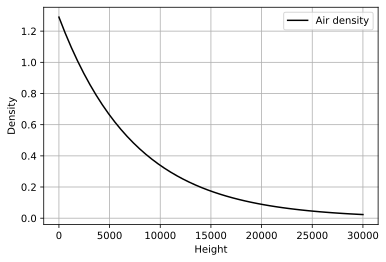

In [7]:
x_values = np.linspace(1,30E3)
plot(density, x_values, label='Air density', xlabel='Height', ylabel='Density')

Henceforth, I will refer to the tuple $(r(t), v(t))$, where $r$ is position and $v$ is velocity, as the generalized coordinates of the system at a certain point in time $t$. Using this concept, we can define the derivative of the generalized coordinates tuple, which we implement in python provided the differential equation.

In [8]:
def derivatives(generalized_coordinates, time, params):
    ''' Returns a list of the form [r'(t), r''(t)], the derivative of the
    generalized coordinate tuple [r(t), r'(t)]'''
    # these implicitly depend on time
    position, velocity = generalized_coordinates

    mass, cross_sec, fric_coeff = params
    constant = (cross_sec*fric_coeff)/2
    derivatives = [velocity,
                   -mass*9.8 + constant*density(position)*velocity**2]
    return derivatives

I create a list `df` containing dataframes with information for each initial condition. Later on we loop over this list to plot the graphs of the required functions.

In [42]:
init_states = [[30E3,0], [40E3,0], [50E3,0], [60E3,0], [70E3,0]]
#                m   A    delta
static_params = (60, 0.3, 0.5)
time_domain = np.linspace(0, 100, 10000)

generalized_coords = [0]*len(init_states)
df = [0]*len(init_states)
i = 0
for init_state in init_states:
    generalized_coords[i] = integrate.odeint(derivatives, init_state,
                                             time_domain, args=(static_params,))
    df[i] = pd.DataFrame({'Height': generalized_coords[i][:, 0], 'Velocity': generalized_coords[i][:, 1]})
    i += 1

We obtain, for instance, the following dataframe:

In [46]:
df[0]

,Height,Velocity
0,30000.000000,0.000000
1,29999.970575,-5.880386
2,29999.882365,-11.759558
3,29999.735369,-17.636303
4,29999.529617,-23.509410
...,...,...
9995,6356.174899,-119.311603
9996,6354.981711,-119.302075
9997,6353.788618,-119.292548
9998,6352.595621,-119.283023


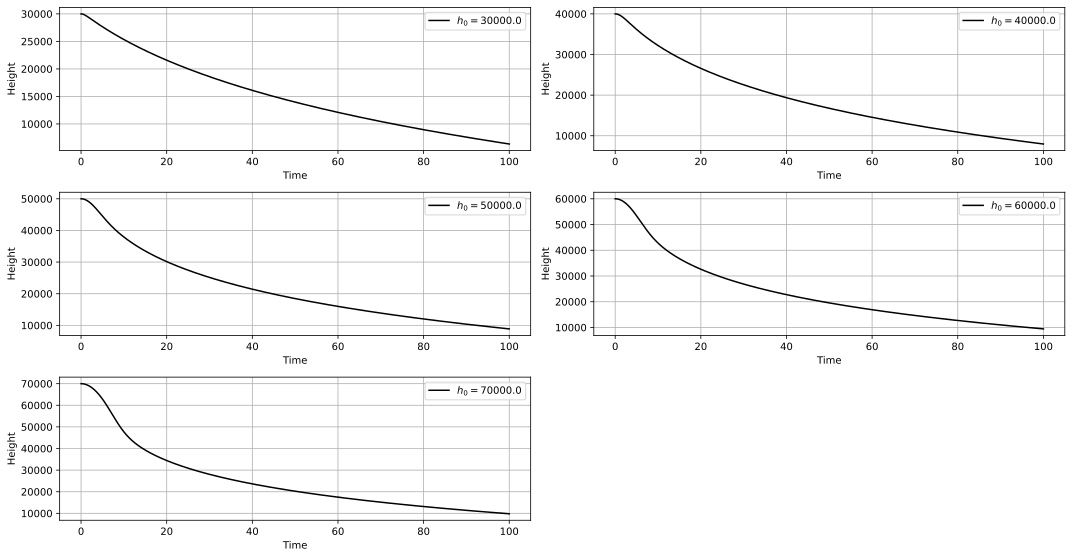

In [11]:
# Using grids to plot the data
fig = plt.figure(figsize=(15,10))

for i in range(len(df)):
    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(time_domain, np.abs(df[i].Height), 'k-', label=rf'$h_0 = ${init_states[i][0]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Height')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

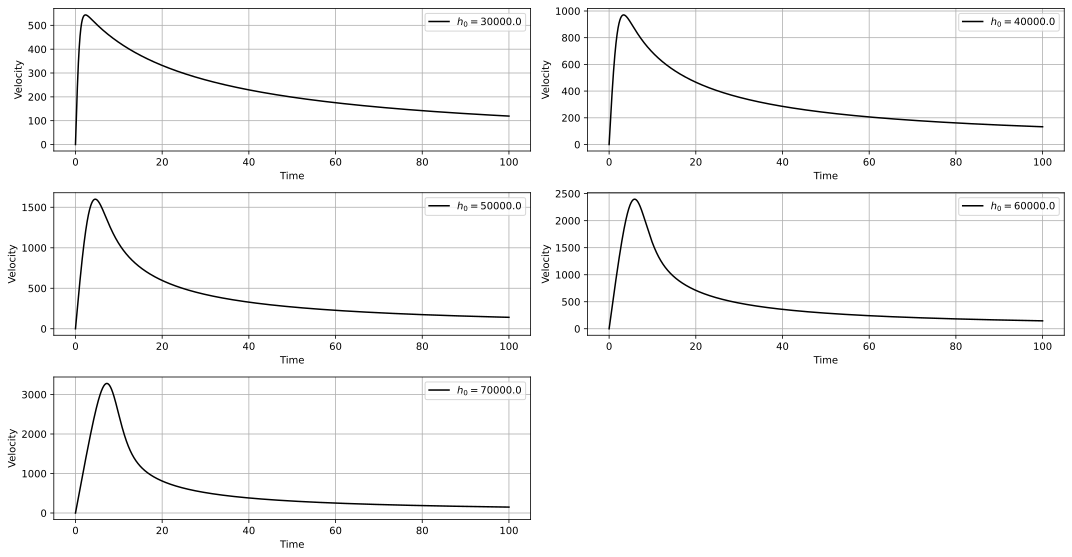

In [12]:
# Using grids to plot the data
fig = plt.figure(figsize=(15,10))

for i in range(len(df)):
    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(time_domain, np.abs(df[i].Velocity), 'k-', label=rf'$h_0 = ${init_states[i][0]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Velocity')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

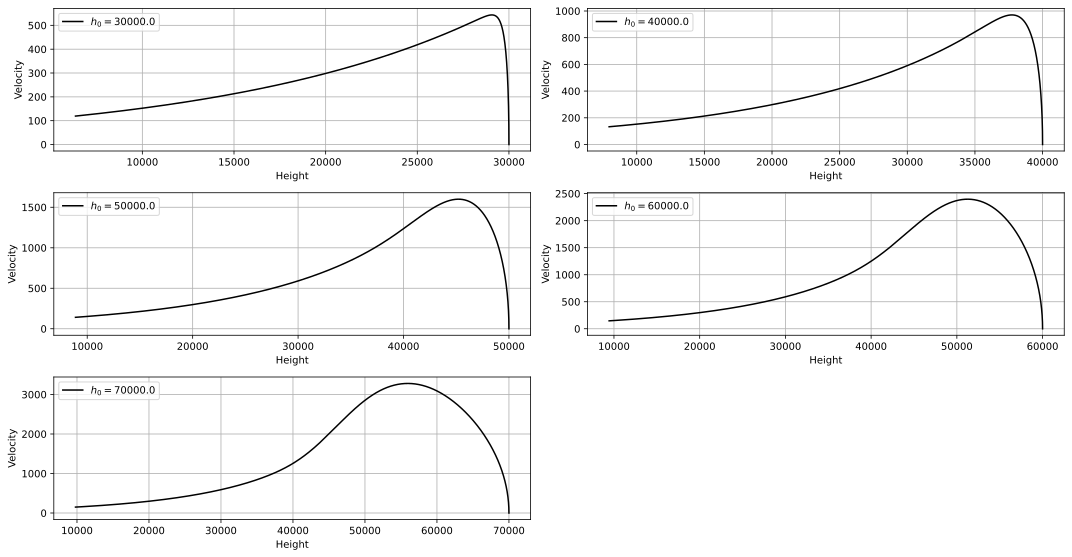

In [13]:
fig = plt.figure(figsize=(15,10))

for i in range(len(df)):
    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(df[i].Height, np.abs(df[i].Velocity), 'k-', label=rf'$h_0 = ${init_states[i][0]}')
    ax.set_xlabel('Height')
    ax.set_ylabel('Velocity')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

We can now find the maximum velocity for each case. We can either just obtain the maximum value with the `max()` method apllied to the dataframes above, or fit the datapoints and find the root of the derivative.

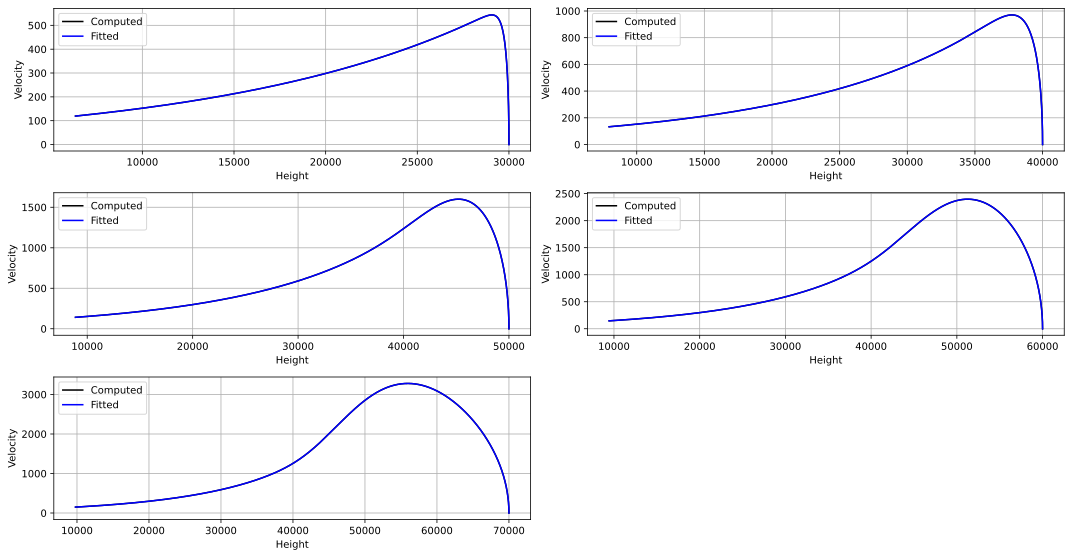

In [14]:
from scipy import optimize
from scipy.interpolate import CubicSpline

max_vels_numerical = np.array([0]*len(df), dtype=float)
max_vels_fit = np.array([0]*len(df), dtype=float)

fig = plt.figure(figsize=(15,10))
for i in range(len(df)):
    velocity_fit = CubicSpline(df[i].Height[::-1], np.abs(df[i].Velocity))
    derivative_velocity_fit = velocity_fit.derivative()

    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(df[i].Height, np.abs(df[i].Velocity), 'k', label='Computed')
    ax.plot(df[i].Height, velocity_fit(df[i].Height[::-1]), 'b', label='Fitted')
    ax.set_xlabel('Height')
    ax.set_ylabel('Velocity')
    ax.legend()
    ax.grid()
    
    max_vels_numerical[i] = max(np.abs(df[i].Velocity))
    max_vels_fit[i] = velocity_fit(optimize.bisect(lambda x: derivative_velocity_fit(x),
                                                   df[i].Height[9999], df[i].Height[0]))
    
plt.tight_layout()
plt.show()

In [15]:
max_vels_fit, max_vels_numerical

(array([ 543.82670799,  970.50632956, 1600.05407657, 2396.96953717,
        3278.87425345]),
 array([ 543.82662761,  970.50587293, 1600.05310907, 2396.96730786,
        3278.87395185]))

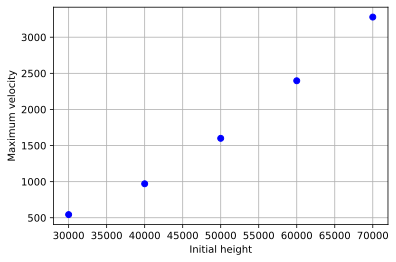

In [16]:
plt.plot([init_state[0] for init_state in init_states], max_vels_fit, 'bo')
plt.xlabel('Initial height')
plt.ylabel('Maximum velocity')
plt.grid()
plt.show()

Now generalizing this process:

In [17]:
def max_vel(init_height, time_domain=np.linspace(0, 100, 10000)):
    init_state = [init_height, 0]
    generalized_coords = integrate.odeint(derivatives, init_state,
                                          time_domain, args=(static_params,))
    
    Height, Velocity = generalized_coords[:,0], generalized_coords[:,1]

    velocity_fit = CubicSpline(Height[::-1], np.abs(Velocity))
    derivative_velocity_fit = velocity_fit.derivative()
    
    max_vel = velocity_fit(optimize.bisect(lambda x: derivative_velocity_fit(x),
                                           Height[9999], Height[0]))
    return max_vel
max_vel(30E3)

array(543.82670799)

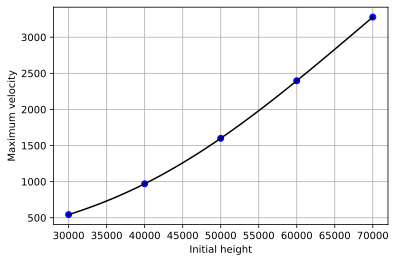

In [18]:
heights = np.linspace(30E3, 70E3)
max_vels = [max_vel(height) for height in heights]

plt.plot([init_state[0] for init_state in init_states], max_vels_fit, 'bo')
plt.plot(heights, max_vels, 'k-')
plt.xlabel('Initial height')
plt.ylabel('Maximum velocity')
plt.grid()
plt.show()

**Challenge**
Now suppose that the gravitational force is given by:
\begin{equation} 
\mathbf{F} =  \frac{GMm}{(R+y)^2} 
\end{equation}

In [35]:
def grav_force(height, mass, G=6.67, M=5.98E13, R=6371E3):
    force = -(G*M)*mass/(R + height)**2
    return force

def alternative_derivatives(generalized_coordinates, time, params):
    ''' Returns a list of the form [r'(t), r''(t)], the derivative of the
    generalized coordinate tuple [r(t), r'(t)]'''
    # these implicitly depend on time
    position, velocity = generalized_coordinates

    mass, cross_sec, fric_coeff = params
    constant = (cross_sec*fric_coeff)/2
    derivatives = [velocity,
                   grav_force(position, mass) + constant*density(position)*velocity**2]
    return derivatives

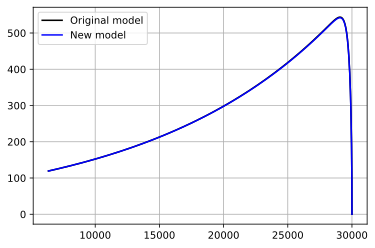

In [41]:
init = [30E3,0]

generalized_coords = integrate.odeint(alternative_derivatives, init,
                                      time_domain, args=(static_params,))

alternative_heights = generalized_coords[:,0]
alternative_velocities = generalized_coords[:,1]

plt.plot(df[0].Height, np.abs(df[0].Velocity), 'k-', label='Original model')
plt.plot(alternative_heights, np.abs(alternative_velocities), 'b-', label='New model')
plt.plot()
plt.grid()
plt.legend()
plt.show()

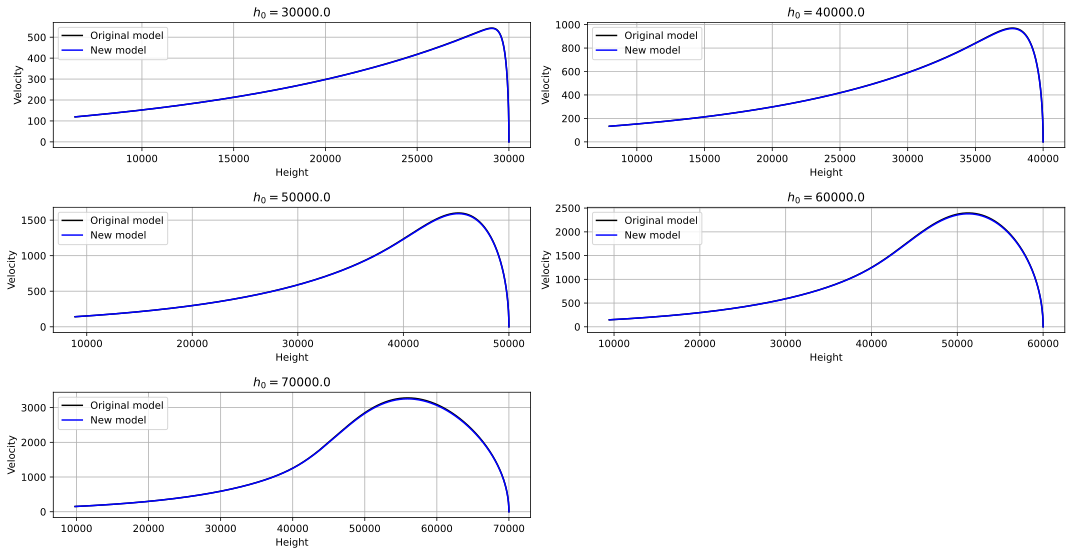

In [45]:
df_alt = [0]*len(init_states)
i = 0
for init_state in init_states:
    generalized_coords[i] = integrate.odeint(alternative_derivatives, init_state,
                                             time_domain, args=(static_params,))
    df_alt[i] = pd.DataFrame({'Height': generalized_coords[i][:, 0], 'Velocity': generalized_coords[i][:, 1]})
    i += 1

fig = plt.figure(figsize=(15,10))

for i in range(len(df)):
    ax = fig.add_subplot(4, 2, i+1)
    ax.set_title(rf'$h_0 = ${init_states[i][0]}')
    ax.plot(df[i].Height, np.abs(df[i].Velocity), 'k-', label='Original model')
    ax.plot(df_alt[i].Height, np.abs(df_alt[i].Velocity), 'b-', label='New model')
    ax.set_xlabel('Height')
    ax.set_ylabel('Velocity')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()